# Train Your Very First Pytorch Model!
Let’s learn through doing.
In this notebook we will create an image classifier to detect Persian Alphabets with Multilayer Perceptron.
We will tackle this problem in 3 parts:
1. Pytorch Dataset
2. Pytorch Model
3. Pytorch Training Loop
Almost every pytorch model training pipeline meets this paradigm.

# Data Processing
Let's start by importing all the modules we'll need. The main ones we need to import are:

* torch for general PyTorch functionality
* torch.nn and torch.nn.functional for neural network based functions
* torch.optim for our optimizer which will update the parameters of our neural network
* torch.utils.data for handling the dataset
* torchvision.transforms for data augmentation
* torchvision.datasets for loading the dataset
* sklearn's metrics for visualizing a confusion matrix
* sklearn's decomposition and manifold for visualizing the neural network's representations in two dimensions
* matplotlib for plotting

In [213]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cdblib as cdb

import sys
import copy
import random
import time


print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.12.3 (main, Nov  6 2024, 18:32:19) [GCC 13.2.0]
PyTorch version 2.5.1+cu124
Torchvision version 0.20.1+cu124
Numpy version 2.2.1
Pandas version 2.2.3


In [294]:
import torch
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

GPU: NVIDIA GeForce RTX 2060 is available.


In [295]:
# To ensure we get reproducible results we set the random seed for Python, Numpy and PyTorch.
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Pytorch Dataset (and Dataloader)
* It’s an organized way to structure how the data and labels are loaded into the model.
* We can then wrap the dataset in a dataloader and pytorch will handle batching the shuffling the data for us when training the model!

In [296]:
class PersianAlphabetDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes 

## Create Test Dataset

In [297]:
train_data = PersianAlphabetDataset(
    data_dir='./HCD/data/train/'
)

In [298]:
len(train_data)

70645

In [299]:
train_data[120]

(<PIL.Image.Image image mode=RGB size=128x128>, 0)

0


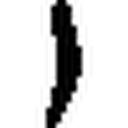

In [300]:
image, label = train_data[200]
print(label)
image

In [301]:
# Get a dictionary associating target values with folder names
data_dir = './HCD/data/train/'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: '00', 1: '01', 2: '02', 3: '03', 4: '04', 5: '05', 6: '06', 7: '07', 8: '08', 9: '09', 10: '10', 11: '11', 12: '12', 13: '13', 14: '14', 15: '15', 16: '16', 17: '17', 18: '18', 19: '19', 20: '20', 21: '21', 22: '22', 23: '23', 24: '24', 25: '25', 26: '26', 27: '27', 28: '28', 29: '29', 30: '30', 31: '31', 32: '32', 33: '33', 34: '34', 35: '35'}


In [302]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
data_dir = './HCD/data/train/'
train_data = PersianAlphabetDataset(data_dir, transform)

In [303]:
image, label = train_data[6000]
image.shape

torch.Size([1, 128, 128])

In [304]:
# iterate over dataset
for image, label in train_data:
    break

# Dataloaders
* Batching our dataset
* It’s faster to train the model in batches instead of one at a time.

In [305]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

In [306]:
for images, labels in train_loader:
    break

In [307]:
images.shape, labels.shape

(torch.Size([64, 1, 128, 128]), torch.Size([64]))

In [308]:
labels

tensor([18,  0, 21,  1, 14, 10, 13,  7,  1,  8,  2,  9,  9, 11,  9, 22, 15, 20,
        26, 34, 13,  2, 18,  0, 26,  2,  1,  1, 13, 17,  8,  6,  6,  7, 24,  4,
        14, 11,  1,  7, 27, 20, 14, 17, 29, 23, 20, 15, 22,  0,  1, 22, 27, 27,
        13, 30,  6,  5, 21, 26, 12, 32, 31, 31])

In [309]:
for images, labels in train_loader:
    break

In [310]:
# Initialize variables for mean and std
mean = 0.0
std = 0.0
total_images = 0

# Calculate mean and std
for images, _ in train_loader:
    # Flatten the image to a 2D array (batch_size, num_pixels)
    images = images.view(images.size(0), -1)
    
    # Update the mean and std
    mean += images.mean(dim=1).sum()
    std += images.std(dim=1).sum()
    total_images += images.size(0)

# Divide by total number of images
mean /= total_images
std /= total_images

# Normalize by 255 as the images are in [0, 1]
mean /= 255
std /= 255

print(f'Calculated mean: {mean.item()}')
print(f'Calculated std: {std.item()}')

KeyboardInterrupt: 

In [236]:
# Define train and test transforms
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(5, fill=(0,)),  # Random rotation for data augmentation
    transforms.RandomCrop(128, padding=2),     # Random crop with padding
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean.item()], std=[std.item()])  # Normalize using calculated mean and std
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean.item()], std=[std.item()])  # Normalize using calculated mean and std
])

In [311]:
# Define train and test transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = './HCD/data/train/'
test_folder = './HCD/data/test/'

# train_data = PersianAlphabetDataset(train_folder, transform=transform)
# test_data = PersianAlphabetDataset(test_folder, transform=transform)
train_data = PersianAlphabetDataset(train_folder, transform=transform)
test_data = PersianAlphabetDataset(test_folder, transform=transform)

In [312]:
# DataLoader for batching
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

In [313]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 70645
Number of testing examples: 17706


In [315]:
def plot_images(images):
    n_images = len(images)

    # Calculate rows and columns for plotting
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(8, 8))
    for i in range(min(rows * cols, len(images))):
        ax = fig.add_subplot(rows, cols, i + 1)
        img = images[i].permute(1, 2, 0).cpu().numpy()  # Reorder dimensions to HWC

        # Denormalize if necessary
        if img.min() < 0 or img.max() > 1:
            img = (img - img.min()) / (img.max() - img.min())

        ax.imshow(img)
        ax.axis('off')
    plt.show()

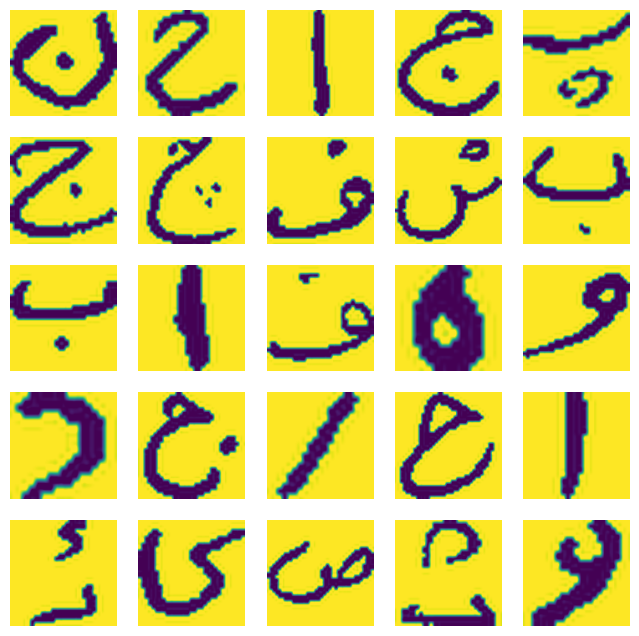

In [316]:
# # Number of images to plot
N_IMAGES = 25

# Randomly sample N_IMAGES from the dataset
indices = random.sample(range(len(train_data)), N_IMAGES)  # Get random indices
images = [train_data[i][0] for i in indices]  # Get image data for the sampled indices

# Plot the images
plot_images(images)

# N_IMAGES = 25

# images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

# plot_images(images)

In [317]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

In [318]:
train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

In [319]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 63580
Number of validation examples: 7065
Number of testing examples: 17706


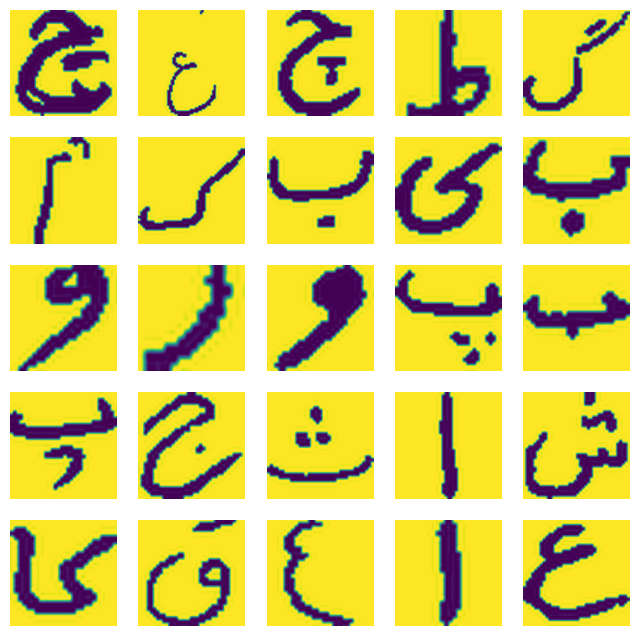

In [320]:
N_IMAGES = 25

images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]]

plot_images(images)

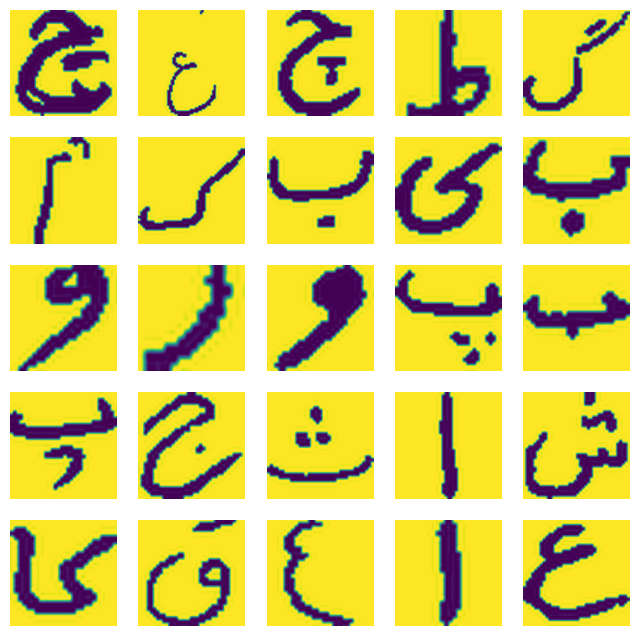

In [321]:
N_IMAGES = 25

images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]]

plot_images(images)

In [322]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

# Pytorch Model
Pytorch datasets have a structured way of organizing your data, pytorch models follow a similar
paradigm.
* We could create the model from scratch defining each layer.
* However for tasks like image classification, many of the state of the art architectures are readily available and we can import them from packages like timm.
* Understanding the pytorch model is all about understanding the shape the data is at each layer, and the main one we need to modify for a task is the final layer. Here we have 53 targets, so we will modify the last layer for this.

# Defining the Model
Our model will be a neural network, specifically a multilayer perceptron (MLP) with two hidden layers. The image below shows the archicture of the model.

In [323]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 4096)
        self.hidden_fc = nn.Linear(4096, 1296)
        self.output_fc = nn.Linear(1296, output_dim)

    def forward(self, x):

        # x = [batch size, height, width]

        batch_size = x.shape[0]

        x = x.view(batch_size, -1)

        # x = [batch size, height * width]

        h_1 = F.relu(self.input_fc(x))

        # h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))

        # h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)

        # y_pred = [batch size, output dim]

        return y_pred, h_2

We'll define our model by creating an instance of it and setting the correct input and output dimensions.

In [324]:
INPUT_DIM = 128 * 128
OUTPUT_DIM = 36

model = MLP(INPUT_DIM, OUTPUT_DIM)

We can also create a small function to calculate the number of trainable parameters (weights and biases) in our model - in case all of our parameters are trainable.

In [325]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

The first layer has 16384 neurons connected to 4096 neurons, so 16384*4096 weighted connections plus 4096 bias terms.

The second layer has 4096 neurons connected to 1296 neurons, 4096*1296 weighted connections plus 1296 bias terms.

The third layer has 1296 neurons connected to 36 neurons, 1296*36 weighted connections plus 36 bias terms.

$$16384 \cdot 4096 + 4096 + 4096 \cdot 1296 + 1296 + 1296 \cdot 36 + 36 = 72,469,364 $$

In [326]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 72,469,364 trainable parameters


# Training the Model
Next, we'll define our optimizer. This is the algorithm we will use to update the parameters of our model with respect to the loss calculated on the data.

We aren't going to go into too much detail on how neural networks are trained but the gist is:
* pass a batch of data through your model
* calculate the loss of your batch by comparing your model's predictions against the actual labels
* calculate the gradient of each of your parameters with respect to the loss
* update each of your parameters by subtracting their gradient multiplied by a small learning rate parameter

We use the Adam algorithm with the default parameters to update our model. Improved results could be obtained by searching over different optimizers and learning rates, however default Adam is usually a good starting off point.

In [327]:
optimizer = optim.Adam(model.parameters())

Then, we define a criterion, PyTorch's name for a loss/cost/error function. This function will take in your model's predictions with the actual labels and then compute the loss/cost/error of your model with its current parameters.

`CrossEntropyLoss` both computes the softmax activation function on the supplied predictions as well as the actual loss via negative log likelihood.

Briefly, the softmax function is:

$$\text{softmax }(\mathbf{x}) = \frac{e^{x_i}}{\sum_j e^{x_j}}$$ 

In [328]:
criterion = nn.CrossEntropyLoss()

We then define `device`. This is used to place your model and data on to a GPU, if you have one.

In [329]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [330]:
print(device)

cuda


We place our model and criterion on to the device by using the `.to` method.

In [331]:
model = model.to(device)
criterion = criterion.to(device)

Next, we'll define a function to calculate the accuracy of our model. This takes the index of the highest value for your prediction and compares it against the actual class label. We then divide how many our model got correct by the amount in the batch to calculate accuracy across the batch.

In [332]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

We finally define our training loop

This will:
- put our model into `train` mode
- iterate over our dataloader, returning batches of (image, label)
- place the batch on to our GPU, if we have one
- clear the gradients calculated from the last batch
- pass our batch of images, `x`, through to model to get predictions, `y_pred`
- calculate the loss between our predictions and the actual labels
- calculate the accuracy between our predictions and the actual labels
- calculate the gradients of each parameter
- update the parameters by taking an optimizer step
- update our metrics

Some layers act differently when training and evaluating the model that contains them, hence why we must tell our model we are in "training" mode. The model we are using here does not use any of those layers, however it is good practice to get used to putting your model in training mode.

In [333]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

The evaluation loop is similar to the training loop. The differences are:
- we put our model into evaluation mode with `model.eval()`
- we wrap the iterations inside a `with torch.no_grad()`
- we do not zero gradients as we are not calculating any
- we do not calculate gradients as we are not updating parameters
- we do not take an optimizer step as we are not calculating gradients

`torch.no_grad()` ensures that gradients are not calculated for whatever is inside the `with` block. As our model will not have to calculate gradients, it will be faster and use less memory. 

In [334]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

The final step before training is to define a small function to tell us how long an epoch took.

In [335]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We're finally ready to train!

During each epoch we calculate the training loss and accuracy, followed by the validation loss and accuracy. We then check if the validation loss achieved is the best validation loss we have seen. If so, we save our model's parameters (called a `state_dict`).

In [336]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/994 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 55s
	Train Loss: 1.050 | Train Acc: 70.50%
	 Val. Loss: 0.679 |  Val. Acc: 77.50%


Training:   0%|          | 0/994 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 4s
	Train Loss: 0.512 | Train Acc: 82.85%
	 Val. Loss: 0.481 |  Val. Acc: 83.72%


Training:   0%|          | 0/994 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 5s
	Train Loss: 0.447 | Train Acc: 85.05%
	 Val. Loss: 0.469 |  Val. Acc: 84.86%


Training:   0%|          | 0/994 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 0s
	Train Loss: 0.399 | Train Acc: 86.52%
	 Val. Loss: 0.499 |  Val. Acc: 84.59%


Training:   0%|          | 0/994 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 1m 5s
	Train Loss: 0.375 | Train Acc: 87.42%
	 Val. Loss: 0.382 |  Val. Acc: 88.01%


Training:   0%|          | 0/994 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 1m 2s
	Train Loss: 0.356 | Train Acc: 87.95%
	 Val. Loss: 0.410 |  Val. Acc: 86.57%


Training:   0%|          | 0/994 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 1m 1s
	Train Loss: 0.342 | Train Acc: 88.49%
	 Val. Loss: 0.407 |  Val. Acc: 87.36%


Training:   0%|          | 0/994 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 1m 1s
	Train Loss: 0.334 | Train Acc: 88.65%
	 Val. Loss: 0.472 |  Val. Acc: 85.70%


Training:   0%|          | 0/994 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 1m 0s
	Train Loss: 0.311 | Train Acc: 89.48%
	 Val. Loss: 0.433 |  Val. Acc: 87.17%


Training:   0%|          | 0/994 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 0s
	Train Loss: 0.318 | Train Acc: 89.39%
	 Val. Loss: 0.416 |  Val. Acc: 88.12%


Afterwards, we load our the parameters of the model that achieved the best validation loss and then use this to evaluate our model on the test set.

In [337]:
model.load_state_dict(torch.load('tut1-model.pt', weights_only=True))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

Evaluating:   0%|          | 0/277 [00:00<?, ?it/s]

Our model achieves 87% accuracy on the test set.

This can be improved by tweaking hyperparameters, e.g. number of layers, number of neurons per layer, optimization algorithm used, learning rate, etc.

In [338]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.395 | Test Acc: 87.28%


# Examining the Model

Now we've trained our model, there are a few things we can look at. Most of these are simple exploratory analysis, but they can offer some insights into your model.

An important thing to do is check what examples your model gets wrong and ensure that they're reasonable mistakes.

The function below will return the model's predictions over a given dataset. It will return the inputs (image) the outputs (model predictions) and the ground truth labels.

In [339]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

We can then get these predictions and, by taking the index of the highest predicted probability, get the predicted labels.

In [340]:
images, labels, probs = get_predictions(model, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

In [341]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(36, 36))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(36))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

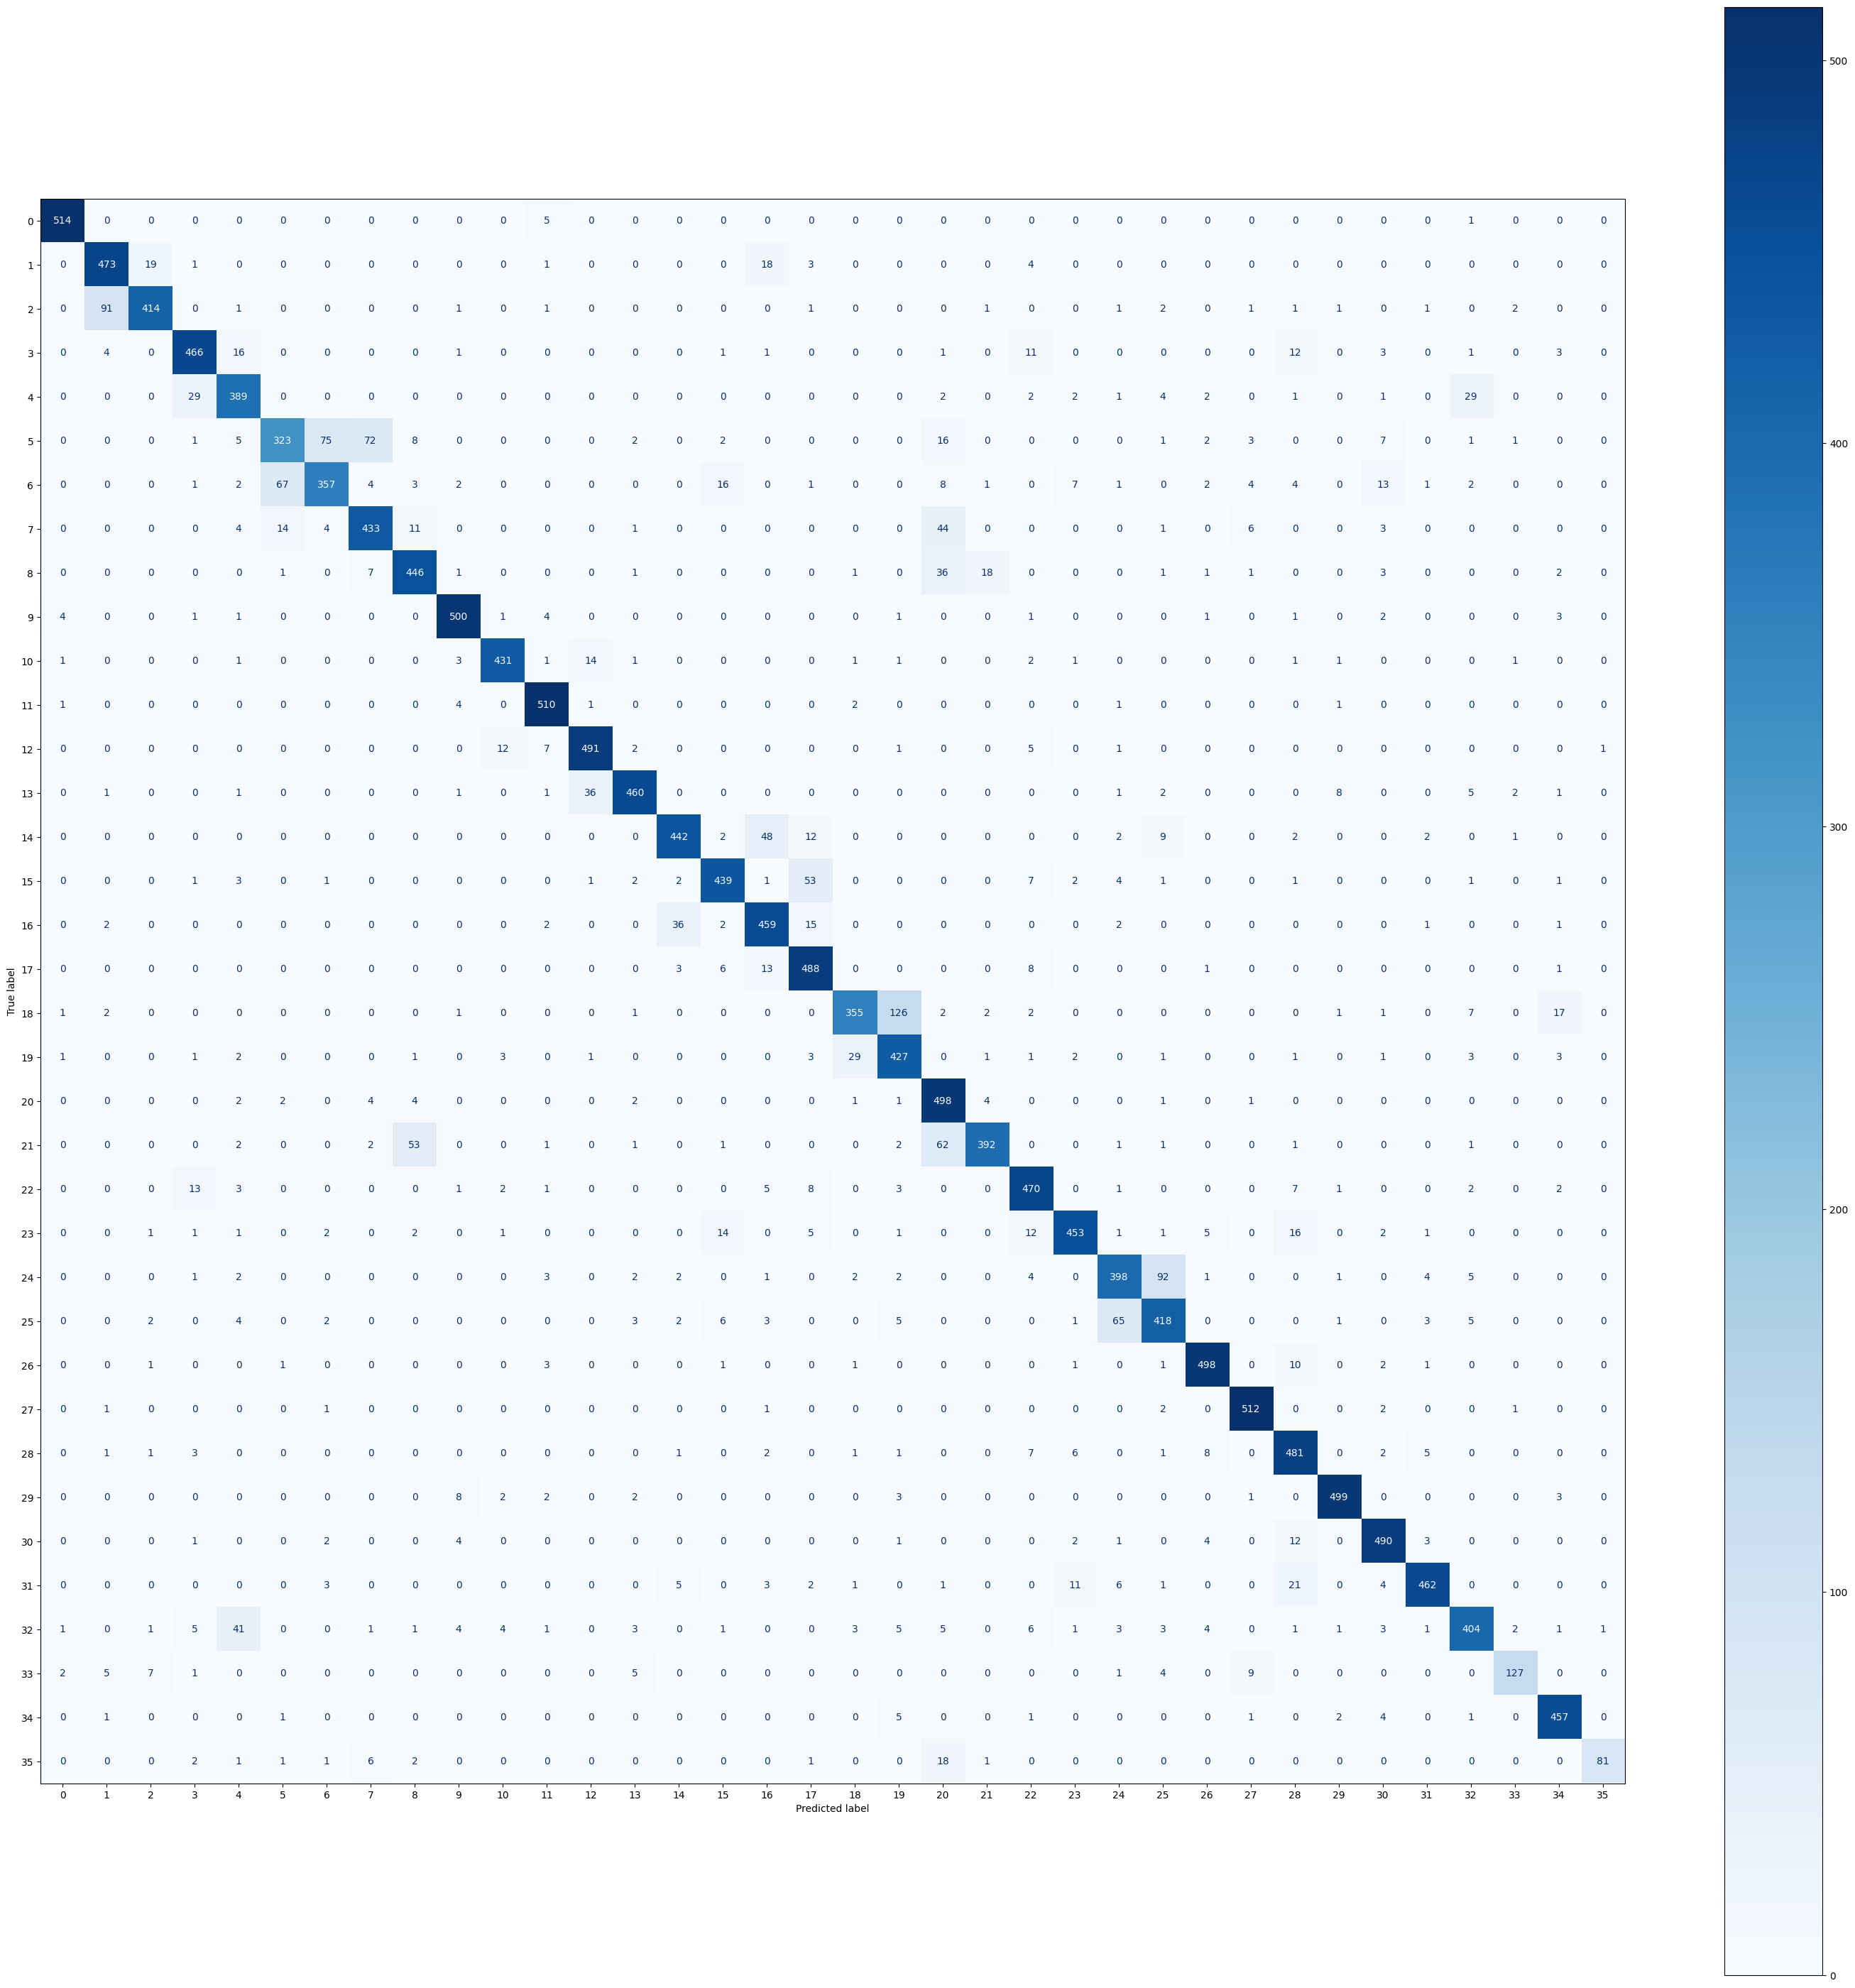

In [342]:
plot_confusion_matrix(labels, pred_labels)

Next, for each of our examples, we can check if our predicted label matches our actual label.

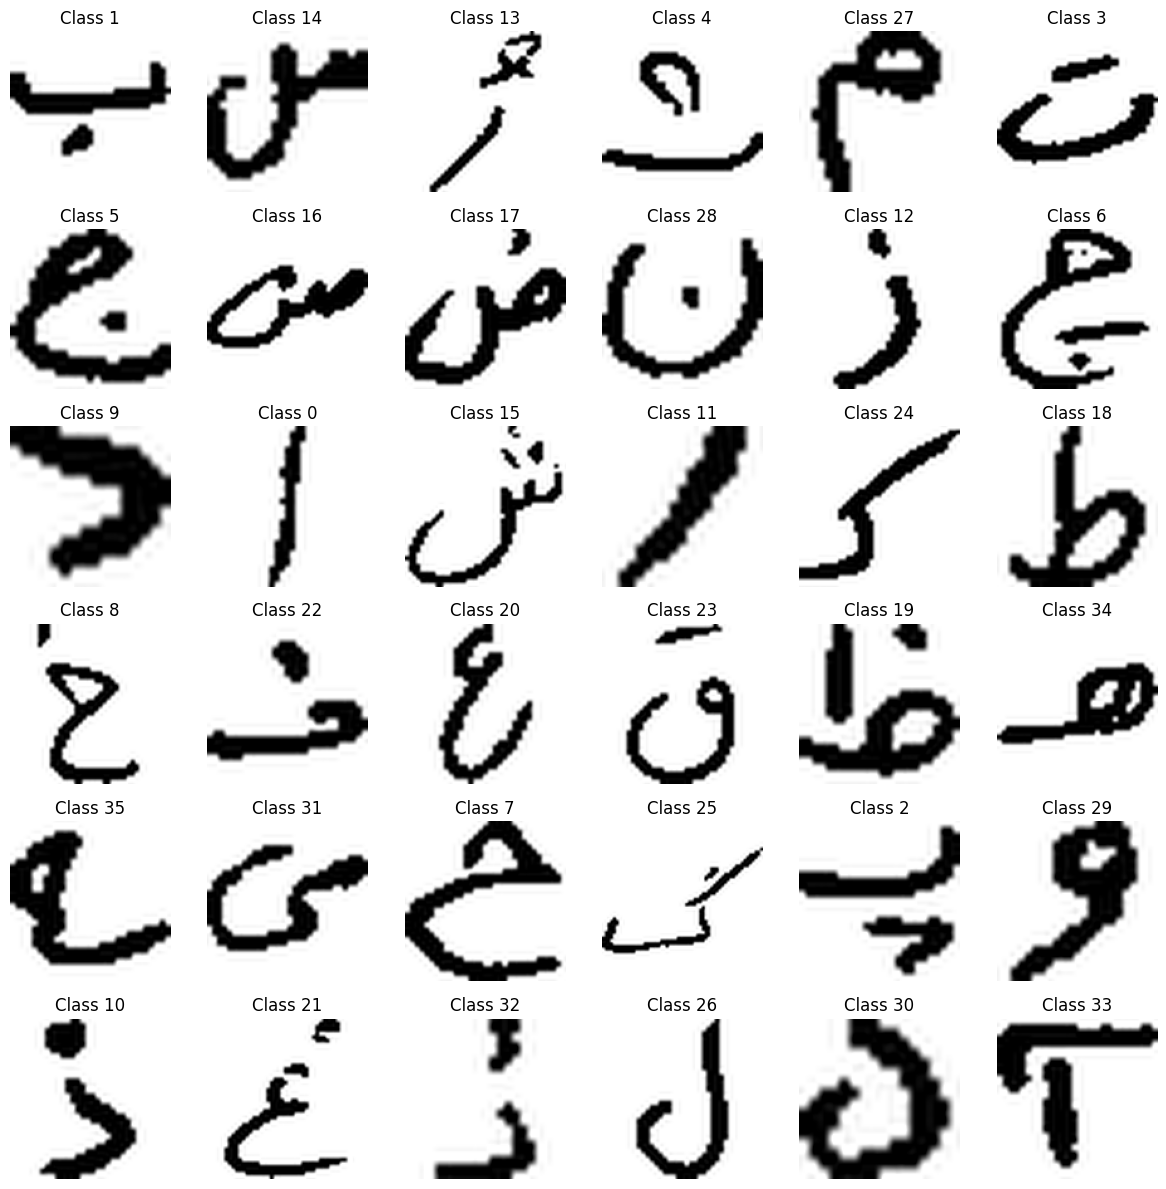

In [344]:
def plot_one_image_per_class(dataset, class_names, grid_size=(6, 6)):
    """
    Plots one representative image for each class in the dataset.

    Args:
        dataset (torch.utils.data.Dataset): The dataset containing the images and labels.
        class_names (list): List of class names corresponding to the labels.
        grid_size (tuple): Size of the grid to plot (rows, columns).
    """
    # Dictionary to store one image per class
    class_images = {}
    
    # Collect one image for each class
    for image, label in dataset:
        if label not in class_images:
            class_images[label] = image
        if len(class_images) == len(class_names):
            break
    
    # Plot the images in a grid
    num_classes = len(class_names)
    rows, cols = grid_size
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    
    for idx, (label, image) in enumerate(class_images.items()):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col]
        ax.imshow(image.squeeze(), cmap="gray")
        ax.set_title(class_names[label])
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming `train_data` and `class_names` are defined
plot_one_image_per_class(train_data, class_names, grid_size=(6, 6))


In [345]:
corrects = torch.eq(labels, pred_labels)

We can then loop through all of the examples over our model's predictions and store all the examples the model got incorrect into an array.

Then, we sort these incorrect examples by how confident they were, with the most confident being first.

In [346]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

We can then plot the incorrectly predicted images along with how confident they were on the actual label and how confident they were at the incorrect label.

In [347]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(128, 128).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

Below we can see the 25 images the model got incorrect and was most confident about.

A lot of these digits are irregular, so it's difficult for the model to do well on these. The images that do look fine, if you squint you can sort of see why the model got it wrong.

Why is the neural network so confident on the irregular digits? Surely if it's a weird looking digit then the output of the softmax should be close to evenly distributed across a few digits the model isn't sure about, right? Well, no. The model has been trained to only be incredibly confident about its predictions, and thus when it sees an image it will always be confident about what it is.

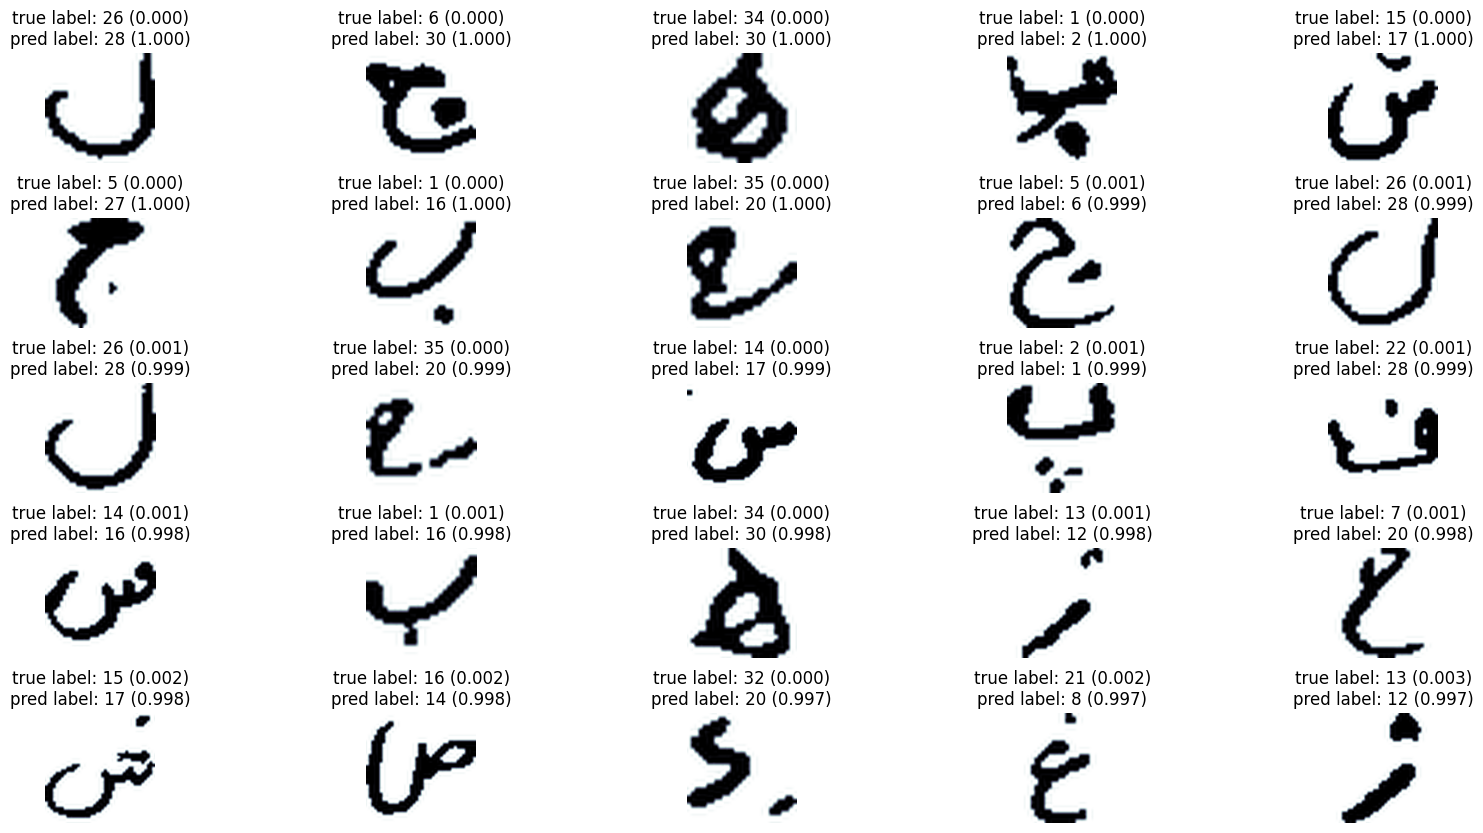

In [348]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

Another thing we can do is get the output and intermediate representations from the model and try to visualize them.

The function below loops through the provided dataset and gets the output from the model and the intermediate representation from the layer before that, the second hidden layer.

In [349]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

In [350]:
outputs, intermediates, labels = get_representations(model,
                                                     train_iterator,
                                                     device)

  0%|          | 0/994 [00:00<?, ?it/s]

In [351]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [352]:
# def plot_representations(data, labels, n_images=None):
#     if n_images is not None:
#         data = data[:n_images]
#         labels = labels[:n_images]
#     fig = plt.figure(figsize=(10, 10))
#     ax = fig.add_subplot(111)
#     scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
#     handles, labels = scatter.legend_elements()
#     ax.legend(handles=handles, labels=labels)

def plot_representations(data, labels, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab20', s=50)  # Use a larger colormap
    legend1 = ax.legend(*scatter.legend_elements(num=36), title="Classes", loc="upper right")
    ax.add_artist(legend1)

    plt.title("Feature Representations")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()


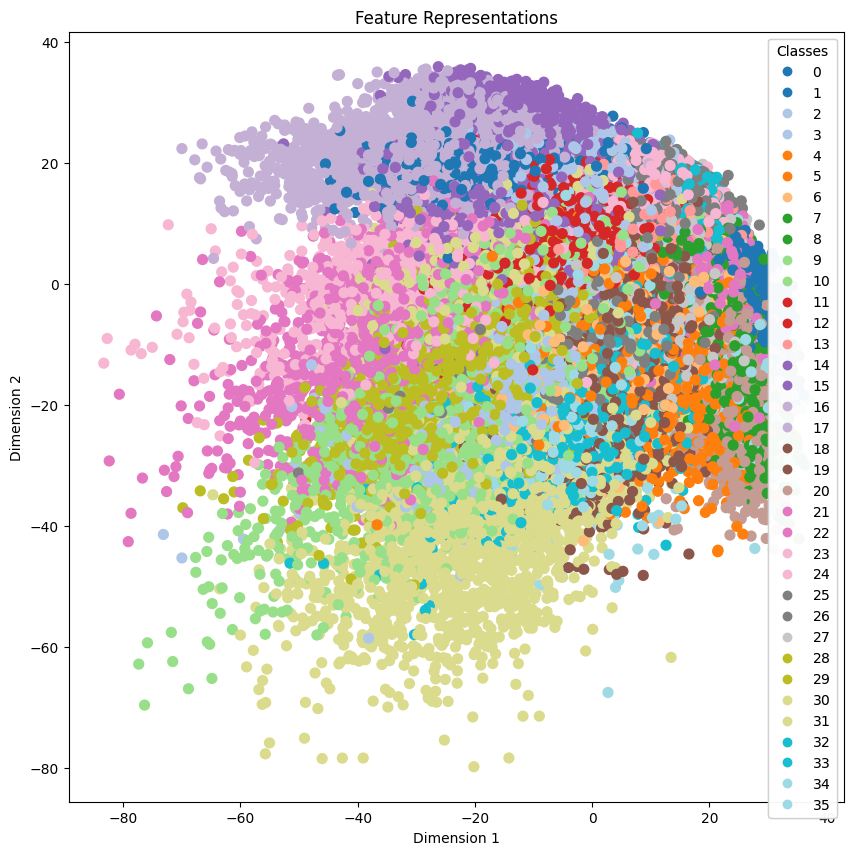

In [353]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels)

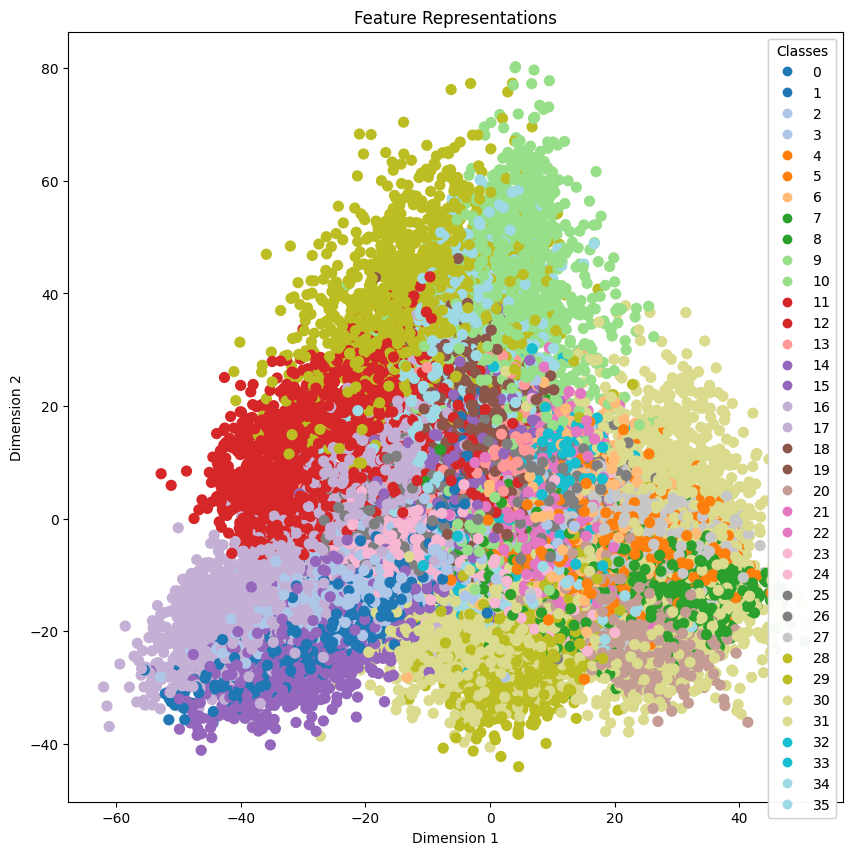

In [356]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels)

In [357]:
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

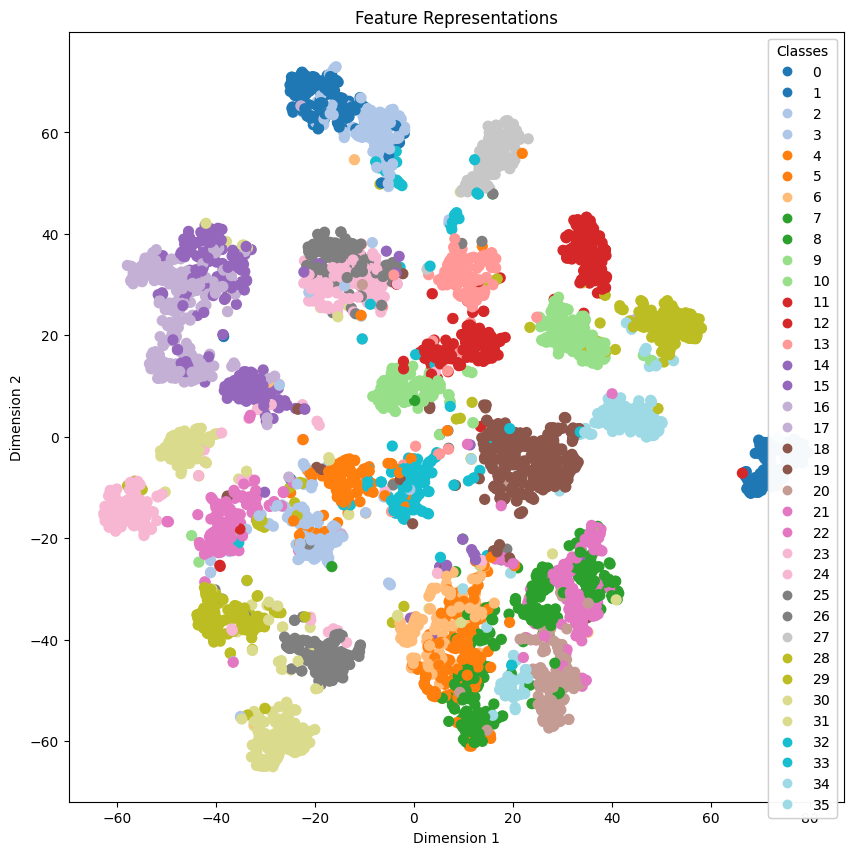

In [358]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, n_images=N_IMAGES)

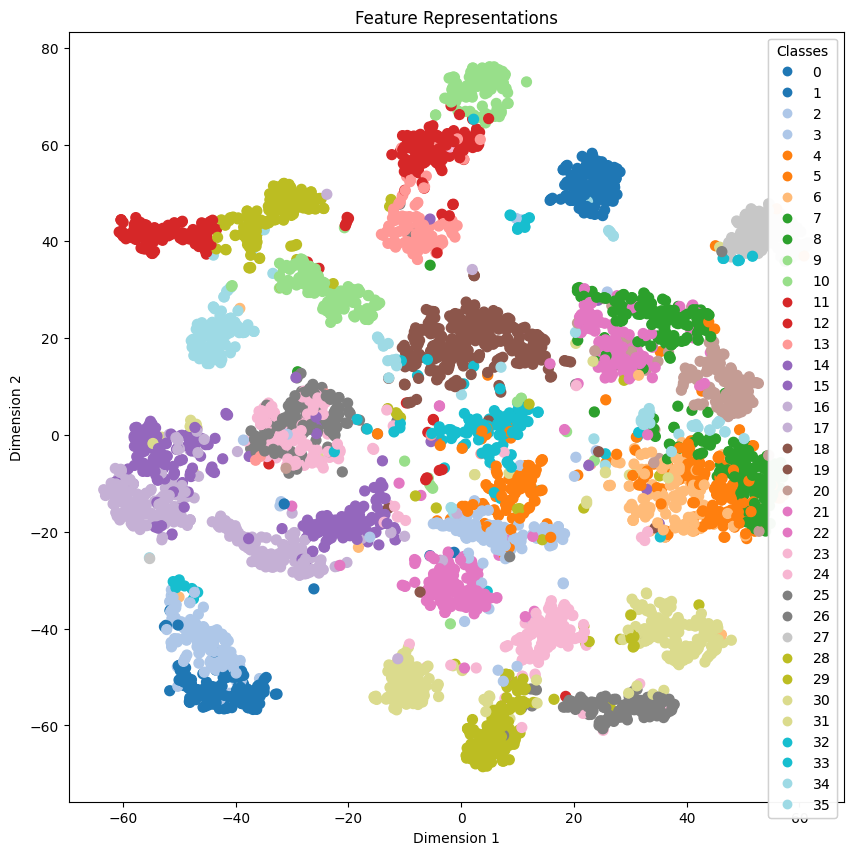

In [375]:
intermediate_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediate_tsne_data, labels, n_images=N_IMAGES)

import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")  # or 'L' if grayscale
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs, _ = model(image_tensor)  # Assuming the model returns a tuple (logits, hidden_state)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

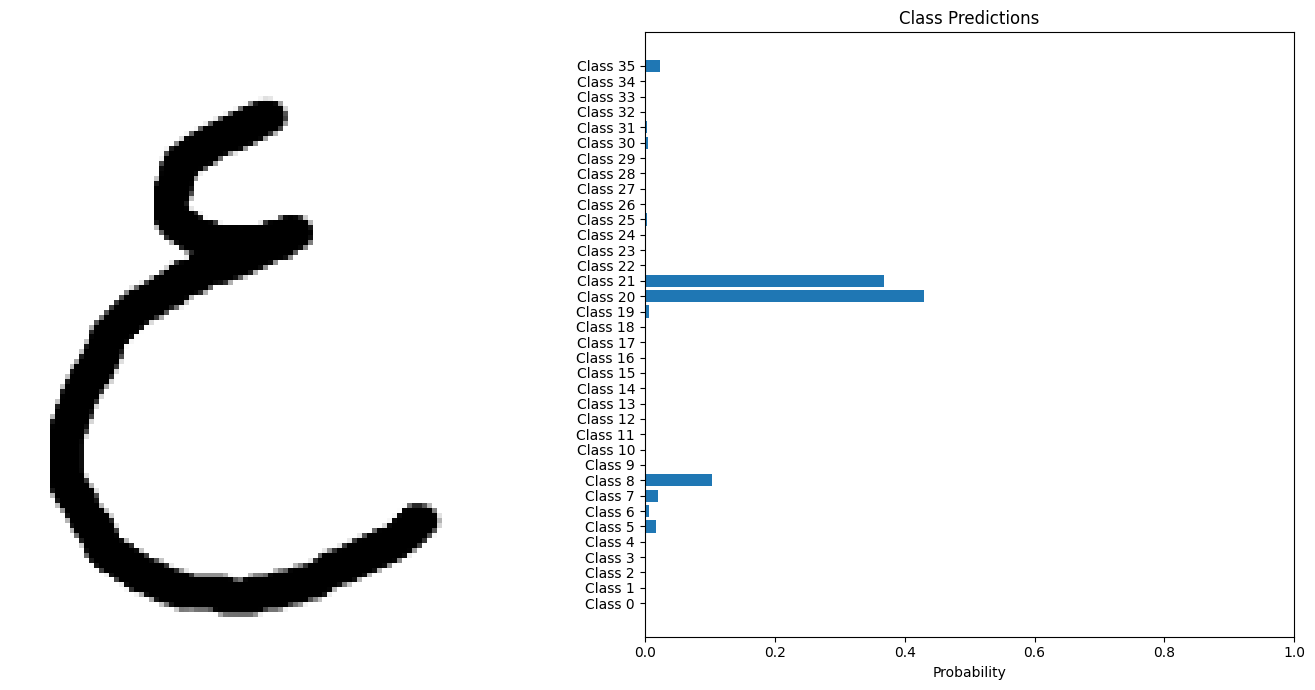

In [394]:
# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = './HCD/data/test-persian/ain.png'  # Provide the correct path
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Assuming you want 28x28
    transforms.Grayscale(num_output_channels=1),  # To match your model input
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)

# Assuming the model is loaded and device is set
probabilities = predict(model, image_tensor, device)

# Define your class names for Persian letters or whatever classes you're using
class_names = [f"Class {i}" for i in range(36)]  # Adjust this to your actual class names
visualize_predictions(original_image, probabilities, class_names)



# # Example usage
# transform = transforms.Compose([
#     transforms.Resize((28, 28)),
#     transforms.Grayscale(num_output_channels=1),
#     transforms.ToTensor(),
# ])

# image_path = './HCD/data/test-hand/ch.png'
# predicted_class = predict_single_image(model, image_path, transform, device)
# print(f'Predicted class: {predicted_class}')

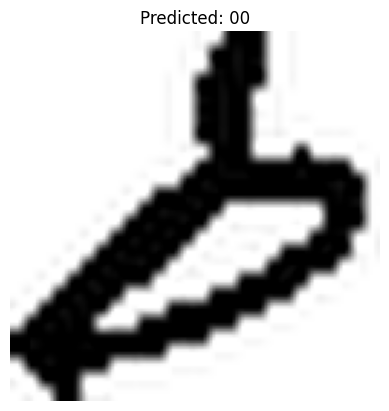

In [364]:
from PIL import Image
import torch
import torchvision.transforms as transforms

# Preprocessing function
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image, image_tensor

# Prediction function
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)  # Get probs from output
    return probabilities.cpu().numpy()

# Visualize Prediction
def visualize_predictions(original_image, probabilities, class_names):
    plt.imshow(original_image)
    plt.axis("off")
    plt.title(f'Predicted: {class_names[probabilities.argmax()]}')
    plt.show()

# Example usage
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

image_path = './HCD/data/test/18/9251.png'  # Your test image path
original_image, image_tensor = preprocess_image(image_path, transform)

# Prediction
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
# class_names = train_data.classes  # This is where class names are stored
class_names = train_data.dataset.classes
visualize_predictions(original_image, probabilities, class_names)